# Customer2Vec

We learn good semantic representations for customers (users) from transactional data using doc2vec. Each customer is a document, orders are sentences, and products are words. We also compare Customer2Vec with the baseline representations obtained using k-means on manually designed features. 

The data we used here is based on Instacart market basket data. It has information like product details, departments etc. Later we create the list of user journey in terms of orders made by a user in chronological order. This will help us in recommending products to customer which they are most likely to add to their cart or just continue their subscription for a particular snack category. It can also help us in retaining customers who can churn in future. 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 8


## Data Exploration and Preparation

In [3]:
os.chdir(r'N:\Digital Marketing Analytics')

### Feature Engineering

In [7]:
prior_orders = pd.read_csv('Olist_Master.csv')
features = ['customer_unique_id', 'order_id', 'product_id', 'product_category_name', 'customer_state', 'review_score', 'order_purchase_timestamp']
#prior_orders = prior_orders.merge(right=orders[['user_id','order_id','order_number']],on='order_id',how='left')
prior_orders = prior_orders[features]
prior_orders.head()

,customer_unique_id,order_id,product_id,product_category_name,customer_state,review_score,order_purchase_timestamp
0,5ee8fe956c2631afc0a1dcc1920d0e3d,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,Cool Stuff,RJ,5,2017-09-13 08:59:02
1,8b3f917f4307d3e5cf34c0b43d6e6f50,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,Cool Stuff,GO,5,2017-06-28 11:52:20
2,69ba88e17ea574da9c9b8c8834a583d1,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,Cool Stuff,MG,4,2018-05-18 10:25:53
3,cbe063493a222cb17024ff0285b4ecb6,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,Cool Stuff,PR,5,2017-08-01 18:38:42
4,ffab5330bd7b40979ab6726b2e02292e,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,Cool Stuff,MG,5,2017-08-10 21:48:40


In [10]:
prior_orders.loc[prior_orders.product_category_name == 'Cool Stuff', 'product_category_name'] = 'Laptops'

In [11]:
prior_orders.columns

Index(['customer_unique_id', 'order_id', 'product_id', 'product_category_name', 'customer_state', 'review_score', 'order_purchase_timestamp'], dtype='object')

In [12]:
prior_orders.shape

(116581, 7)

In [13]:
prior_orders = prior_orders.drop_duplicates()
prior_orders.shape

(101172, 7)

In [33]:
from datetime import datetime
prior_orders['order_purchase_timestamp'] = prior_orders.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))
prior_orders['order_purchase_date'] = prior_orders.order_purchase_timestamp.apply(lambda x : datetime.strftime(x, '%Y-%m-%d'))
prior_orders['order_purchase_date'] = pd.to_datetime(prior_orders['order_purchase_date'])

In [36]:
prior_orders

,customer_unique_id,order_id,product_id,product_category_name,customer_state,review_score,order_purchase_timestamp,order_purchase_date
0,5ee8fe956c2631afc0a1dcc1920d0e3d,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,Laptops,RJ,5,2017-09-13 08:59:02,2017-09-13
1,8b3f917f4307d3e5cf34c0b43d6e6f50,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,Laptops,GO,5,2017-06-28 11:52:20,2017-06-28
2,69ba88e17ea574da9c9b8c8834a583d1,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,Laptops,MG,4,2018-05-18 10:25:53,2018-05-18
3,cbe063493a222cb17024ff0285b4ecb6,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,Laptops,PR,5,2017-08-01 18:38:42,2017-08-01
4,ffab5330bd7b40979ab6726b2e02292e,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,Laptops,MG,5,2017-08-10 21:48:40,2017-08-10
...,...,...,...,...,...,...,...,...
116574,a50a18d0f932c1cf1dec68cc1d281d8a,fd607d0a02cb276bc764a15f80f0423f,02ad78835ec3f72e750d1dfa6a7e11b3,Furniture Decor,BA,5,2018-07-26 09:13:04,2018-07-26
116576,e060eb8f37de232154b24bbb2413b68e,fdaf98feac227eb978d8f33f36e0231d,f739e9151702508b18f796c53005e5e9,Furniture Decor,RJ,4,2017-04-19 10:20:51,2017-04-19
116577,3041f5d65c4fa516eed1325d7a8657af,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,Electronics,SP,4,2017-08-11 10:15:22,2017-08-11
116578,57b628f46c00f9a7358e5e875d5b4dd0,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,Computers,ES,1,2018-07-25 18:10:17,2018-07-25


In [42]:
prior_orders.groupby(['customer_unique_id', 'product_id'])['order_purchase_date'].nunique()

customer_unique_id                product_id                      
0000b849f77a49e4a4ce2b2a4ca5be3f  64d33e6bd1b905a31c2f96f584e6a0c8    1
                                  f8ea5fcf9c628485e01b9c3cf52728c2    1
0000f46a3911fa3c0805444483337064  0705b33fb285827a578fce4899f1b921    1
                                  5328338cfaa16ba10561cd970c73ca11    1
                                  c20d93bddf6dbfdaffdfda9e9a2e0d7b    1
                                                                     ..
fffbf87b7a1a6fa8b03f081c5f51a201  1a6c9da4039deae58c2b769f049ae121    1
                                  7934d547a892c625b8f469a2242961c3    1
fffcc512b7dfecaffd80f13614af1d16  4d614d466f2eba2e50e683ebb1460351    1
fffea47cd6d3cc0a88bd621562a9d061  083ffd30820b592e294de7ed668ff975    1
                                  917b949f2215f3567f3e01deb87138f9    1
Name: order_purchase_date, Length: 100891, dtype: int64

In [47]:
temp = prior_orders.sort_values(by=['customer_unique_id'], ascending=True)
prior_orders = temp.iloc[:20000, :]

In [48]:
prior_orders = prior_orders.reset_index(drop=True)
prior_orders['List Index'] = prior_orders.index
customers_group = prior_orders.groupby("customer_unique_id")
customers_group

In [49]:
total = []
for customer_unique_id, curCust in customers_group:
    temp = np.zeros(len(prior_orders))

    for num, Product in curCust.iterrows():
        temp[Product['List Index']] = Product['review_score'] / 5.0

    total.append(temp)


In [50]:
len(total)

8159

In [52]:
import random
random.shuffle(total)
train = total[:7000]
valid = total[7000:]

In [57]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

hiddenUnits = 64
visibleUnits = len(prior_orders)

# Number of unique movies
vb = tf.placeholder(tf.float32, [visibleUnits])

# Number of features that we are going to learn
hb = tf.placeholder(tf.float32, [hiddenUnits])
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits]) 

In [43]:
# Sample users to keep the problem computationaly tractable 
USER_SUBSET = 15000
np.random.seed(42)
user_ids_sample = prior_orders['customer_unique_id'].sample(n=USER_SUBSET, replace=False)

In [58]:
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  # Visible layer activation
# Gibb's Sampling
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

In [59]:
# Hidden layer activation
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)  
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [60]:
# Learning rate
alpha = 0.6

# Creating the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

In [61]:
# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [62]:
#Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [63]:
# Current weight
cur_w = np.random.normal(loc=0, scale=0.01, size=[visibleUnits, hiddenUnits])

# Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

# Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

# Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)


In [64]:
# Running the session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [65]:
def free_energy(v_sample, W, vb, hb):
    ''' Function to compute the free energy '''
    wx_b = np.dot(v_sample, W) + hb
    vbias_term = np.dot(v_sample, vb)
    hidden_term = np.sum(np.log(1 + np.exp(wx_b)), axis = 1)
    return -hidden_term - vbias_term

In [66]:
epochs = 60
batchsize = 100
errors = []
energy_train = []
energy_valid = []
for i in range(epochs):
    for start, end in zip(range(0, len(train), batchsize), range(batchsize, len(train), batchsize)):
        batch = train[start:end]
        cur_w = sess.run(update_w, feed_dict={
                         v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={
                          v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={
                          v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb

    energy_train.append(np.mean(free_energy(train, cur_w, cur_vb, cur_hb)))
    energy_valid.append(np.mean(free_energy(valid, cur_w, cur_vb, cur_hb)))

    errors.append(sess.run(err_sum, feed_dict={
                  v0: train, W: cur_w, vb: cur_vb, hb: cur_hb}))
    if i % 10 == 0:
        print("Error in epoch {0} is: {1}".format(i, errors[i]))


Error in epoch 0 is: 0.00021576366270892322
Error in epoch 10 is: 0.00018954234838020056
Error in epoch 20 is: 0.00019080234051216394
Error in epoch 30 is: 0.00019309947674628347
Error in epoch 40 is: 0.0001904766249936074
Error in epoch 50 is: 0.00018690664728637785


Text(0.5,0,'Epoch')

Text(0,0.5,'Free Energy')

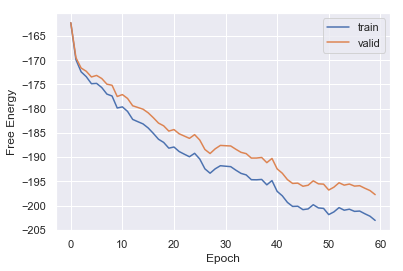

In [67]:
fig, ax = plt.subplots()
ax.plot(energy_train, label='train')
ax.plot(energy_valid, label='valid')
leg = ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Free Energy")
plt.savefig("free_energy.png")
plt.show()

Text(0.5,0,'Epoch')

Text(0,0.5,'Error')

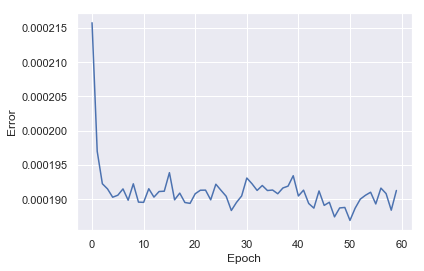

In [68]:
plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.savefig("error.png")
plt.show()

In [104]:
user = 100
inputUser = [train[user]]
inputUser

[array([0., 0., 0., ..., 0., 0., 0.])]

In [105]:
# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})


In [106]:
# Creating recommendation score for books in our data
prior_orders["Recommendation Score"] = rec[0]

# Find the mock user's user_id from the data
cur_user_id = prior_orders.iloc[user]['customer_unique_id']

# Find all books the mock user has read before
prods_ordered = prior_orders[prior_orders['customer_unique_id'] == cur_user_id]['product_id']

# converting the pandas series object into a list
read_prod_id = prods_ordered.tolist()

# getting the book names and authors for the books already read by the user
order_prod_names = []
#read_prod_authors = []
for prod in read_prod_id:
    order_prod_names.append(
        prior_orders[prior_orders['product_id'] == prod]['product_category_name'].tolist()[0])
    

In [107]:
read_prod_id

['f6c8384f424cad1a22fd89bbc62ff7ae',
 'c03500a4a72be532834b3d947821d519',
 '586328f570ac0b651d452f1227db4d1c']

In [108]:
all_prod = prior_orders.product_id.unique()
all_prod_id = all_prod.tolist()
len(all_prod_id)

11043

In [109]:
# Find all books the mock user has 'not' read before using the to_read data
unbought_prod = list(set(all_prod_id) - set(read_prod_id))
len(unbought_prod)

11040

In [110]:
# extract the ratings of all the unread books from ratings dataframe
unbought_with_score = prior_orders[prior_orders['product_id'].isin(unbought_prod)]

# grouping the unread data on book id and taking the mean of the recommendation scores for each book_id
grouped_unbought = unbought_with_score.groupby('product_id', as_index=False)[
    'Recommendation Score'].mean()

In [111]:
# getting the names and authors of the unread books
unbought_prod_names = []
unbought_prod_scores = []
for product in grouped_unbought['product_id']:
    unbought_prod_names.append(
        prior_orders[prior_orders['product_id'] == product]['product_category_name'].tolist()[0])
    unbought_prod_scores.append(
        grouped_unbought[grouped_unbought['product_id'] == product]['Recommendation Score'].tolist()[0])


In [137]:
# creating a data frame for unbought products with their names and recommendation scores
unbought_prod_with_scores = pd.DataFrame({
    'Product_name': unbought_prod_names,
    'score': unbought_prod_scores
})

# creating a data frame for read books with the names and authors
buy_prod_with_names = pd.DataFrame({
    'Product_name': order_prod_names
})

# sort the result in descending order of the recommendation score
sorted_result = unbought_prod_with_scores.sort_values(
    by='score', ascending=False)

# exporting the read and unread books  with scores to csv files
buy_prod_with_names.to_csv('buy_prod_with_names.csv')
sorted_result.to_csv('unbought_prod_with_scores.csv')
print('The Products bought by the user are:')
print(buy_prod_with_names)
print('The Products recommended to the user are:')
print(sorted_result)

The Products bought by the user are:
    Product_name
0       Pet Shop
1       Pet Shop
2  Watches Gifts
The Products recommended to the user are:
          Product_name     score
1251              Auto  0.000589
3073   Furniture Decor  0.000569
10540      Electronics  0.000499
5501        Housewares  0.000489
9075   Furniture Decor  0.000468
...                ...       ...
9951        Stationery  0.000002
6265    Bed Bath Table  0.000002
10496    Watches Gifts  0.000002
9712   Furniture Decor  0.000002
6078   Furniture Decor  0.000001

[11040 rows x 2 columns]


In [138]:
sorted_result = sorted_result[:100].groupby(['Product_name']).score.sum()
sorted_result.sort_values(ascending=False)

Product_name
Sports Leisure                     0.004830
Furniture Decor                    0.003623
Housewares                         0.003184
Watches Gifts                      0.003162
Bed Bath Table                     0.003036
Auto                               0.002934
Health Beauty                      0.002334
Computers Accessories              0.001846
Garden Tools                       0.001456
Consoles Games                     0.001228
Toys                               0.001215
Electronics                        0.000908
Fixed Telephony                    0.000851
Telephony                          0.000810
Perfumery                          0.000764
Fashion Bags Accessories           0.000758
Stationery                         0.000751
Luggage Accessories                0.000746
Home Appliances                    0.000701
Market Place                       0.000465
Fashion Shoes                      0.000443
Home Construction                  0.000428
Construction Tools 